In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
%matplotlib inline

In [2]:
train_file_path = "./train.csv"
dataset = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset.shape))
dataset = dataset.drop('ID', axis=1)

Full train dataset shape is (6000, 9)


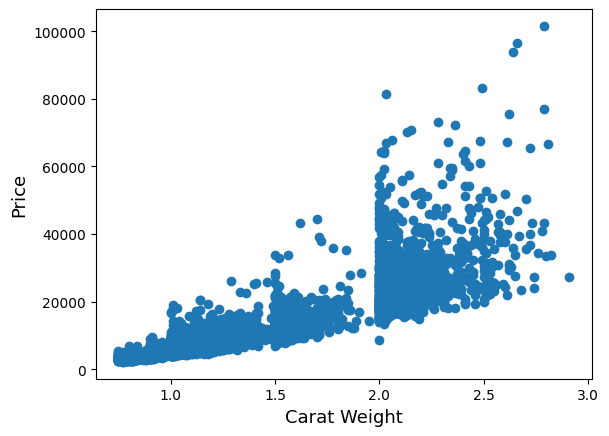

In [3]:
fig, ax = plt.subplots()
ax.scatter(dataset['Carat Weight'], dataset['Price'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('Carat Weight', fontsize=13)
plt.show()


 mu = 11791.58 and sigma = 10183.50



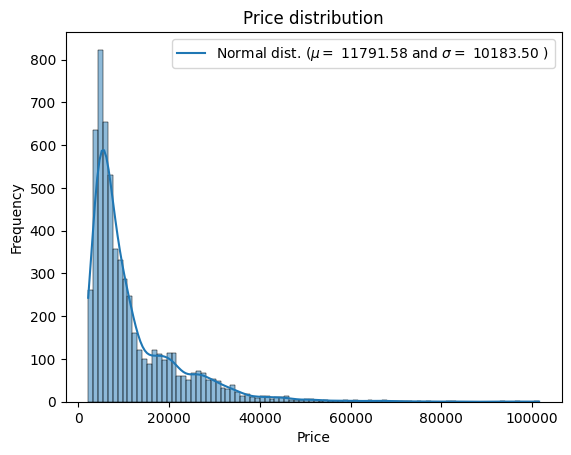

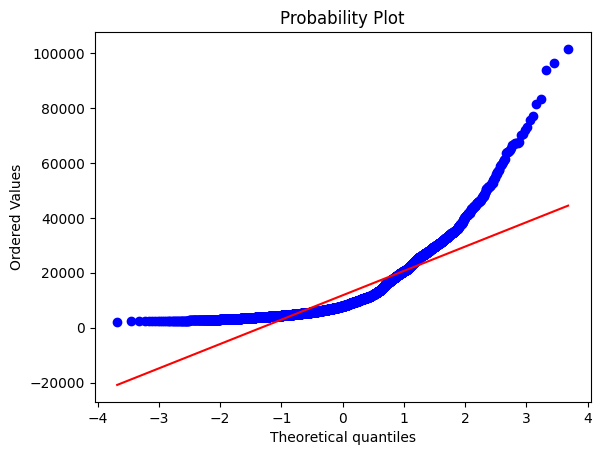

In [4]:
sns.histplot(dataset['Price'], kde=True)
(mu, sigma) = stats.norm.fit(dataset['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(dataset['Price'], plot=plt)
plt.show()


 mu = 9.10 and sigma = 0.71



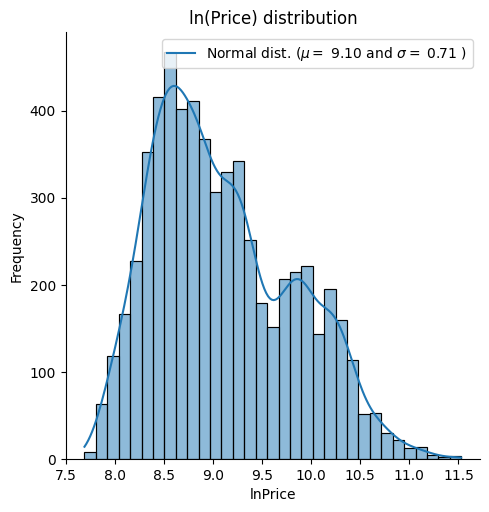

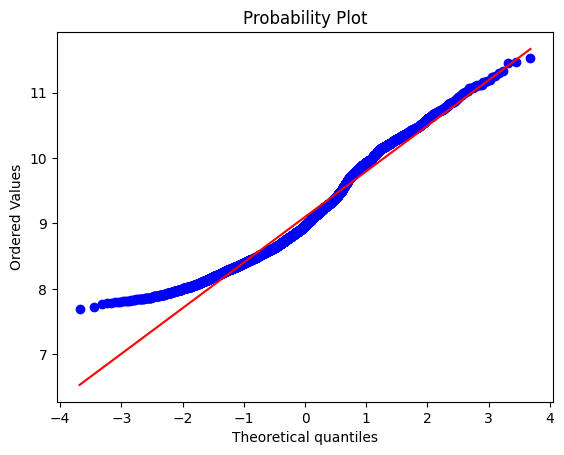

In [5]:
dataset["lnPrice"] = dataset["Price"].map(np.log1p)
# dataset["lnPrice"] = stats.boxcox(dataset["Price"][0]

sns.displot(dataset['lnPrice'], kde=True)
(mu, sigma) = stats.norm.fit(dataset['lnPrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('ln(Price) distribution')

fig = plt.figure()
res = stats.probplot(dataset['lnPrice'], plot=plt)
plt.show()

In [6]:
cat_cols = {
    "Cut": ['Poor', 'Fair', 'Good','Very Good', 'Ideal', 'Signature-Ideal'],
    "Color": ["I", "H", "G", "F", "E", "D"],
    "Clarity": ['SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'FL'],
    "Symmetry": ["G", "VG", "EX", "ID"], 
    "Polish": ["G", "VG", "EX", "ID"],
    "Report": ["GIA", "AGSL"]
}

ds2 = dataset.copy(deep=True)
for key in cat_cols.keys():
    ds2[key] = ds2[key].map(cat_cols[key].index)
ds2 = ds2.drop(["Price"], axis=1)

# corrmat = ds2.corr(numeric_only=True)
# plt.subplots(figsize=(9,8))
# sns.heatmap(corrmat, vmax=0.9, square=True)

<Axes: >

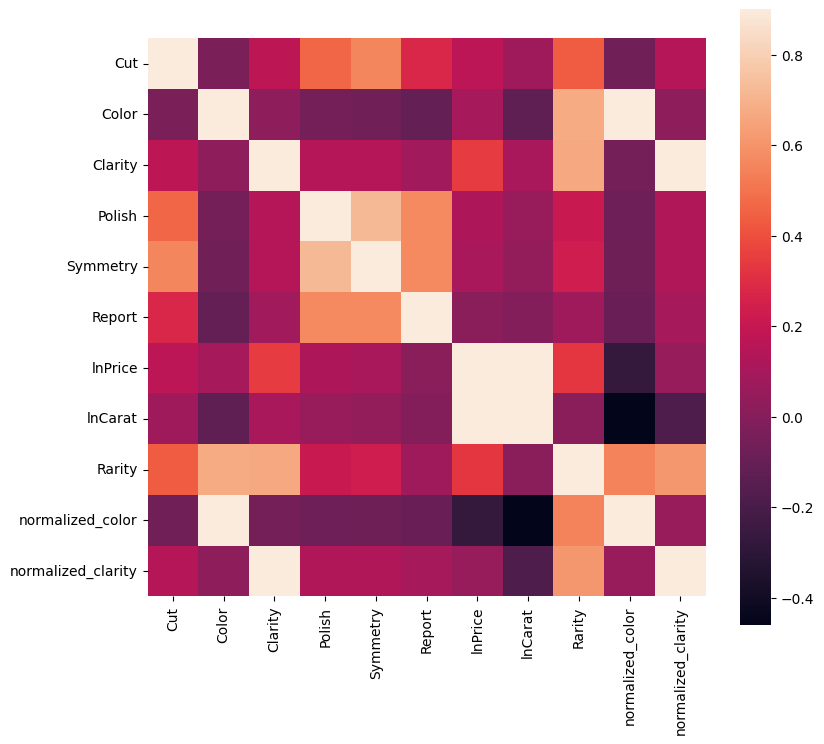

In [7]:
# Preprocess the Dataset
def preprocessX(dataset):
    # Log transform Price and Carat Weight, we will drop the
    # Primary categories later on
    dataset["lnPrice"] = dataset["Price"].map(np.log1p)
    dataset["lnCarat"] = dataset["Carat Weight"].map(np.log1p)
    
    # Feature Engineering
    # dataset['color_clarity'] = dataset['Color'] + "_" + dataset['Clarity']
    # dataset["sym_polish"] = dataset["Symmetry"] + "_" + dataset["Polish"]
    # One hot encode color_clarity and sym_polish:
    # col_clar_dummies = pd.get_dummies(dataset['color_clarity'], dtype=float, drop_first=True)
    # sym_pol_dummies = pd.get_dummies(dataset['sym_polish'], dtype=float, drop_first=True)
    # dataset = pd.concat([dataset, col_clar_dummies, sym_pol_dummies], axis=1)
    
    # Ordinal Encode the categories
    for key in cat_cols.keys():
        dataset[key] = dataset[key].map(cat_cols[key].index)
    
    dataset["Rarity"] = dataset["Color"] + dataset["Clarity"] + dataset["Cut"]
    dataset["normalized_color"] = dataset["Color"] / dataset["Carat Weight"]
    dataset["normalized_clarity"] = dataset["Clarity"] / dataset["Carat Weight"]
    dataset = dataset.drop(["Price", "Carat Weight"], axis=1)
    return dataset

dataset = preprocessX(dataset)
dataset.head()

corrmat = dataset.corr(numeric_only=True)
plt.subplots(figsize=(9,8))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [8]:
def split_dataset(dataset, test_ratio=0.25):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

x_train, x_test = split_dataset(dataset)
print("{} examples in training, {} examples in testing.".format(
    len(x_train), len(x_test)))

y_train = x_train.pop('lnPrice')
y_test = x_test.pop('lnPrice')
y_test = y_test.map(np.exp);

4496 examples in training, 1504 examples in testing.


In [9]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import xgboost as xgb

In [10]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,
                             random_state =7, nthread = -1)

n_models = {"Lasso":lasso, "ENet":ENet, "KRR":KRR, "GBoost":GBoost, "XGB":model_xgb}

In [11]:
def score_model(y_test, y_pred, title):
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred) * 100
    print("{:s} r2: {:.4f} mape: {:.4f}\n".format(title, r2, mape))

for key in n_models.keys():
    instance = clone(n_models[key])
    instance.fit(x_train, y_train)
    y_pred = instance.predict(x_test)
    y_pred = pd.Series(y_pred).map(np.exp)
    score_model(y_test, y_pred, key)

Lasso r2: 96.1932 mape: 8.9106

ENet r2: 96.1925 mape: 8.9055

KRR r2: 97.6638 mape: 6.5788

GBoost r2: 98.5944 mape: 4.6645

XGB r2: 98.4325 mape: 5.1384



In [12]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   



In [13]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))
averaged_models.fit(x_train, y_train)
predictions =  averaged_models.predict(x_test)
predictions = pd.Series(predictions).map(np.exp)
score_model(y_test, predictions, "Averaged")


Averaged r2: 97.8355 mape: 6.5062



In [14]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [15]:
stacked_average_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)
stacked_average_models.fit(x_train, y_train)
predictions =  stacked_average_models.predict(x_test)
predictions = pd.Series(predictions).map(np.exp)
score_model(y_test, predictions, "Stacked")

Stacked r2: 98.7098 mape: 4.5145



In [16]:
test_file_path = "./test.csv"
test_set = pd.read_csv(test_file_path)
print("Full test dataset shape is {}".format(test_set.shape))
ids = test_set['ID']
test_set = test_set.drop('ID', axis=1)



Full test dataset shape is (3142, 9)


In [17]:
y_all = dataset["lnPrice"]
dataset = dataset.drop("lnPrice", axis=1)

test_set = preprocessX(test_set)
test_set.pop("lnPrice")

stacked_average_models.fit(dataset, y_all)

predictions =  stacked_average_models.predict(test_set)
predictions = pd.Series(predictions).map(np.exp)

predictions = predictions.rename("Price")

output = ids.to_frame().join(predictions)
print("Writing output...")
output.to_csv("submission.csv", float_format='%.2f', index=False)


Writing output...


4.30# MAPE!
